# Yield Model Calculator for W2W hybrid bonding
#### Author: Zhichao Chen
#### Date: Aug 25, 2025
#### Description: YAP+ (pad-layout-aware yield analysis)

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
from utils.util import *
import os
import time
import matplotlib.pyplot as plt
from assembly_yield_calculator import Assembly_Yield_Calculator
from pad_bitmap_generation import pad_bitmap_generate_random

The avg_num_defects_per_unit_area file exists, removing it...
PAD_ARR_ROW: 1000
PAD_ARR_COL: 1000
Number of pad blocks: 625
Pad block size: 40
Number of critical pad blocks: 625
Number of redundant pad blocks: 0
Number of dummy pad blocks: 0
Pad bitmap collections info saved.
Wafer initialization time: 0.04238724708557129 seconds.
The maximum allowed misalignment is 2304.3806696833776 nm.
0.05604319206203685  nm
-0.33449929645838405  nm
7.499019525040064  nm
7.499688656592207  nm
far_pad_misalignment_samples 26.905838861213432  nm
Overlay yield calculation time: 0.7719359397888184 seconds.
avg_num_defects1:  0.0013306749296016333 avg_num_defects2:  2.0205947326746356e-06
Defect yield calculation time: 0.11348247528076172 seconds.
upper_limit:  0
lower_limit:  -29.15
Cu expansion yield calculation time: 0.012826681137084961 seconds.
===Consumed time for this iteration:  0.9501562118530273
overlay_yield_list:  [1.0]
defect_yield_list:  [0.8842930652552516]
Cu_expansion_yield_list:  [0.99

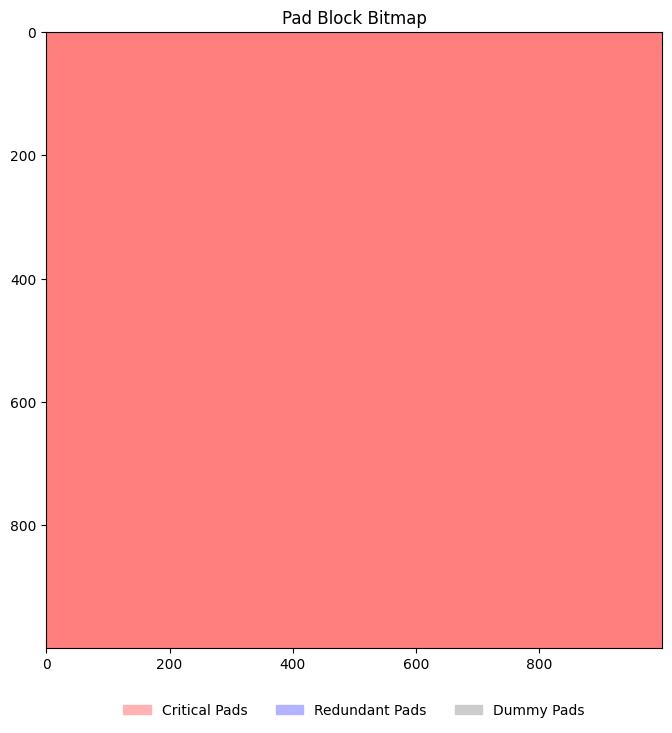

In [5]:
# Load configuration
cfg = load_modeling_config(path='configs/config.yaml', 
                     mode='w2w_modeling',
                     debug=False)

num_points = 1 # Number of points for parameter sweep

# Parameter lists that you want to sweep
die_size_list = np.linspace(10e3, 10e3, num_points)
pitch_list = np.linspace(10, 10, num_points)
particle_density_list = np.logspace(-9, -9, num_points)
t_0_list = np.linspace(0.1, 0.1, num_points)
dish_std_list = np.linspace(1, 1, num_points)
translation_list = np.linspace(0, 0, num_points)
rotation_mean_list = np.linspace(5e-8, 5e-8, num_points)
Roughness_sigma_list = np.linspace(1.0e-9, 1.0e-9, num_points)
PAD_BOT_R_ratio_list = np.linspace(0.5, 0.5, num_points)
PAD_TOP_R_ratio_list = np.linspace(2/3, 2/3, num_points)
bow_difference_mean_list = np.linspace(0.5, 0.5, num_points)
reuse_dilation = False       # You can set this flag to be True to reuse the dilation result
                            # For example, when you are sweeping particle densities, pad layout is not changing,
                            # so you can reuse the dilation result to save computation time

# Yield list containers
yield_dict = {}

if os.path.exists('pad_bitmap/avg_num_defects_per_unit_area.npy'):
    print("The avg_num_defects_per_unit_area file exists, removing it...")
    os.remove('pad_bitmap/avg_num_defects_per_unit_area.npy')
else:
    print("The avg_num_defects_per_unit_area file does not exist, no need to remove.")

# Generate pad bitmap collection
# cfg.redundant_logical_pad_dist = redundant_logical_pad_dist_list[j-1]  # Set the redundant logical pad distance
    
    
# Now the parameter iteration will not change the bitmap
# So you can put this bitmap generation outside the loop

assembly_yield_list = []
overlay_yield_list = []
defect_yield_list = []
Cu_expansion_yield_list = []

# cfg.DEBUG = True
for i in range(num_points):
    # print("Calculating {}-th iteration...".format(i+1))
    # Update parameters
    cfg.DIE_W = float(die_size_list[i])  # die width (um)
    cfg.DIE_L = float(die_size_list[i])  # die length (um)
    cfg.PITCH = float(pitch_list[i])  # pitch (um)
    cfg.PAD_TOP_R_ratio = float(PAD_TOP_R_ratio_list[i])  # top Cu pad radius ratio
    cfg.PAD_BOT_R_ratio = float(PAD_BOT_R_ratio_list[i])  # bottom Cu pad radius ratio
    cfg.SYSTEM_TRANSLATION_X_MEAN = float(translation_list[i])  # systematic translation mean (um) - x direction
    cfg.SYSTEM_TRANSLATION_Y_MEAN = float(translation_list[i])  # systematic translation mean (um) - y direction
    cfg.SYSTEM_ROTATION_MEAN = float(rotation_mean_list[i])  # systematic rotation mean (rad)
    cfg.D0 = float(particle_density_list[i])  # particle density (um^{-2})
    cfg.t_0 = float(t_0_list[i])  # smallest particle thickness (um)
    cfg.BOW_DIFFERENCE_MEAN = float(bow_difference_mean_list[i])  # bow difference mean (um)
    cfg.TOP_DISH_STD = float(dish_std_list[i])  # Top Cu pad dish standard deviation (nm)
    cfg.BOT_DISH_STD = float(dish_std_list[i])  # Bottom Cu pad dish standard deviation (nm)
    cfg.Roughness_sigma = float(Roughness_sigma_list[i])  # Surface roughness standard deviation (m)
    cfg.redundant_logical_pad_dist = 2.0


    # Update above parameters in the configuration
    update_config_items(cfg=cfg, mode='w2w_modeling')

    if cfg.PITCH >= 1.0:
        if reuse_dilation == False or not os.path.exists('pad_bitmap/avg_num_defects_per_unit_area.npy'):
            pad_bitmap_collection = pad_bitmap_generate_random(cfg=cfg,
                                                            pad_layout_pattern='center')
    else:
        print("Pitch is too small, read existing pad bitmap collection.")
        pad_bitmap_collection = np.load('pad_bitmap/bitmap_collection.npy', allow_pickle=True).item()
        pad_bitmap_collection["pad_block_size"] = cfg.pad_block_size
        pad_bitmap_collection["num_critical_pads"] = cfg.PAD_ARR_ROW * cfg.PAD_ARR_COL * cfg.critical_pad_ratio
        pad_bitmap_collection["num_redundant_logical_pads"] = cfg.PAD_ARR_ROW * cfg.PAD_ARR_COL * cfg.redundant_pad_ratio * cfg.redundant_logical_pad_ratio
        pad_bitmap_collection["redundant_logical_pad_copy"] = cfg.redundant_logical_pad_copy



    
    start_time = time.time()
    # Calculate the yield
    assembly_yield, overlay_yield, defect_yield, Cu_expansion_yield = Assembly_Yield_Calculator(
        cfg=cfg, 
        pad_bitmap_collection=pad_bitmap_collection,
    )
    assembly_yield_list.append(assembly_yield)
    overlay_yield_list.append(overlay_yield)
    defect_yield_list.append(defect_yield)
    Cu_expansion_yield_list.append(Cu_expansion_yield)
    print("===Consumed time for this iteration: ", time.time() - start_time)
print("overlay_yield_list: ", overlay_yield_list)
print("defect_yield_list: ", defect_yield_list)
print("Cu_expansion_yield_list: ", Cu_expansion_yield_list)
print("assembly_yield_list: ", assembly_yield_list)
    

In [ ]:
defect_yield_list

In [ ]:
particle_density_list = np.logspace(-10, -8, 10)
dist_40_1 = [0.9947529389581428,
 0.9912627250241163,
 0.9854679270390292,
 0.9758769077499095,
 0.9600853942380516,
 0.9343101624615938,
 0.8928451472018013,
 0.8277318314256372,
 0.7295107440595593,
 0.5909123851543143]
dist_40_2 = [0.9949099057162848,
 0.9915236564255642,
 0.9859006804241397,
 0.9765918631376481,
 0.9612590000519452,
 0.9362160749902759,
 0.895885374347591,
 0.8324387350012609,
 0.7364437765696795,
 0.6003098777332905]
dist_40_3 = [0.9949099057162848,
 0.9915236564255642,
 0.9859006804241397,
 0.9765918631376481,
 0.9612590000519452,
 0.9362160749902759,
 0.895885374347591,
 0.8324387350012609,
 0.7364437765696795,
 0.6003098777332905]

dist_40_1 = np.array(dist_40_1)
dist_40_2 = np.array(dist_40_2)
dist_40_3 = np.array(dist_40_3)

# plot the calculated yield vs. the simulated yield
plt.figure(dpi=150)
plt.plot(particle_density_list, dist_40_1, label='dist_40_1')
plt.plot(particle_density_list, dist_40_2, label='dist_40_2')
plt.plot(particle_density_list, dist_40_3, label='dist_40_3')
plt.xscale('log')
plt.xlabel('Particle Density (um^-2)')
plt.ylabel('Void Defect Yield')
plt.title('Yield v.s. replica distance (W,L=10x10)')
plt.legend()
plt.show()

### pitch 10 um, chip size 3.2x3.2 mm^2, 1 critical pad block, dist=400um

In [ ]:
particle_density_list = np.logspace(-9, -8.1, 10)
model_pos_dict = np.load('yield_dict_3d2_40.npy', allow_pickle=True).item()
plt.figure(dpi=100)
for key in model_pos_dict:
    plt.plot(particle_density_list, model_pos_dict[key], label=f'model_pos_{key}')
plt.xscale('log')
plt.xlabel('Particle Density (um^-2)')
plt.ylabel('Void Defect Yield')
plt.title('Different Position (t0=0.1um, W,L=3.2mm, dist=400um)')
plt.show()

# Calculate the standard deviation of the yield across all positions
defect_yield_list = np.array([model_pos_dict[key] for key in model_pos_dict])
mean_defect_yield = np.mean(defect_yield_list, axis=0)
std_defect_yield = np.std(defect_yield_list, axis=0)
print("Mean defect yield: ", mean_defect_yield)
print("Standard deviation of defect yield: ", std_defect_yield)
# # plot the mean yield and the standard deviation
# plt.figure(dpi=150)
# plt.plot(particle_density_list, mean_defect_yield, label='Mean Defect Yield')
# plt.fill_between(particle_density_list, mean_defect_yield - std_defect_yield, mean_defect_yield + std_defect_yield, alpha=0.2, label='Standard Deviation')
# plt.xscale('log')
# plt.xlabel('Particle Density (um^-2)')
# plt.ylabel('Void Defect Yield')
# plt.title('Mean and Standard Deviation of Defect Yield')
# plt.legend()
# plt.show()


### pitch 10 um, chip size 3.2x3.2 mm^2, 1 critical pad block, dist=800um

In [ ]:
particle_density_list = np.logspace(-9, -6.9, 10)
model_pos_dict = np.load('yield_dict_3d2_80.npy', allow_pickle=True).item()
plt.figure(dpi=100)
for key in model_pos_dict:
    plt.plot(particle_density_list, model_pos_dict[key], label=f'model_pos_{key}')
plt.xscale('log')
plt.xlabel('Particle Density (um^-2)')
plt.ylabel('Void Defect Yield')
plt.title('Different Position (t0=0.1um, W,L=3.2mm, dist=800um)')
plt.show()

# Calculate the standard deviation of the yield across all positions
defect_yield_list = np.array([model_pos_dict[key] for key in model_pos_dict])
mean_defect_yield = np.mean(defect_yield_list, axis=0)
std_defect_yield = np.std(defect_yield_list, axis=0)
print("Mean defect yield: ", mean_defect_yield)
print("Standard deviation of defect yield: ", std_defect_yield)

### pitch 10 um, chip size 3.2x3.2 mm^2, 1 critical pad block, dist=1200um

In [ ]:
particle_density_list = np.logspace(-9, -6.9, 10)
model_pos_dict = np.load('yield_dict_3d2_120.npy', allow_pickle=True).item()
plt.figure(dpi=100)
for key in model_pos_dict:
    plt.plot(particle_density_list, model_pos_dict[key], label=f'model_pos_{key}')
plt.xscale('log')
plt.xlabel('Particle Density (um^-2)')
plt.ylabel('Void Defect Yield')
plt.title('Different Position (t0=0.1um, W,L=3.2mm, dist=1200um)')
plt.show()

# Calculate the standard deviation of the yield across all positions
defect_yield_list = np.array([model_pos_dict[key] for key in model_pos_dict])
mean_defect_yield = np.mean(defect_yield_list, axis=0)
std_defect_yield = np.std(defect_yield_list, axis=0)
print("Mean defect yield: ", mean_defect_yield)
print("Standard deviation of defect yield: ", std_defect_yield)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 文件配置
file_info_list = [
    ("yield_dict_3d2_40.npy", "dist = 40μm"),
    ("yield_dict_3d2_80.npy", "dist = 80μm"),
    ("yield_dict_3d2_120.npy", "dist = 120μm")
]

particle_density_list = np.logspace(-9, -6.9, 10)
base_positions = np.arange(1, len(particle_density_list) + 1)
width = 0.2  # 控制箱型图宽度
offsets = [-0.2, 0, 0.2]  # 控制不同组的横坐标偏移

colors = ['skyblue', 'lightgreen', 'salmon']

plt.figure(dpi=100)

for i, (filename, label) in enumerate(file_info_list):
    model_pos_dict = np.load(filename, allow_pickle=True).item()
    defect_yield_array = np.array([model_pos_dict[key] for key in model_pos_dict])  # shape: (1000, 10)

    data_for_boxplot = defect_yield_array.T  # shape: (10, 1000)
    mean_yields = np.mean(data_for_boxplot, axis=1)
    normalized_data = data_for_boxplot #/ np.mean(data_for_boxplot, axis=1, keepdims=True)

    # 偏移位置，防止不同组重叠
    pos = base_positions #+ offsets[i]

    # 绘制箱型图
    bp = plt.boxplot(
        normalized_data.T,
        positions=pos,
        widths=width,
        patch_artist=True,
        showfliers=False  # 去掉离群值圆圈
    )
    
    # 上色
    for patch in bp['boxes']:
        patch.set_facecolor(colors[i])
    
    # 添加图例
    plt.plot([], c=colors[i], label=label)

plt.xlabel("Index (Sorted by Mean Yield)")
plt.ylabel("Defect Yield")
plt.title("Yield Distribution Comparison at Different Distances (3.2×3.2mm²)")
plt.xticks(base_positions, [f"{i+1}" for i in range(len(base_positions))])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



### pitch 10 um, chip size 7.2x7.2 mm^2, 1 critical pad block, dist=400um

In [ ]:
particle_density_list = np.logspace(-10, -7.7, 10)
model_pos_dict = np.load('yield_dict_7d2_40.npy', allow_pickle=True).item()
plt.figure(dpi=100)
for key in model_pos_dict:
    plt.plot(particle_density_list, model_pos_dict[key], label=f'model_pos_{key}')
plt.xscale('log')
plt.xlabel('Particle Density (um^-2)')
plt.ylabel('Void Defect Yield')
plt.title('Different Position (t0=0.1um, W,L=7.2mm, dist=400um)')
plt.show()

# Calculate the standard deviation of the yield across all positions
defect_yield_list = np.array([model_pos_dict[key] for key in model_pos_dict])
mean_defect_yield = np.mean(defect_yield_list, axis=0)
std_defect_yield = np.std(defect_yield_list, axis=0)
print("Mean defect yield: ", mean_defect_yield)
print("Standard deviation of defect yield: ", std_defect_yield)


### pitch 10 um, chip size 7.2x7.2 mm^2, 1 critical pad block, dist=800um

In [ ]:
particle_density_list = np.logspace(-10, -7.7, 10)
model_pos_dict = np.load('yield_dict_7d2_80.npy', allow_pickle=True).item()
plt.figure(dpi=100)
for key in model_pos_dict:
    plt.plot(particle_density_list, model_pos_dict[key], label=f'model_pos_{key}')
plt.xscale('log')
plt.xlabel('Particle Density (um^-2)')
plt.ylabel('Void Defect Yield')
plt.title('Different Position (t0=0.1um, W,L=7.2mm, dist=800um)')
plt.show()

# Calculate the standard deviation of the yield across all positions
defect_yield_list = np.array([model_pos_dict[key] for key in model_pos_dict])
mean_defect_yield = np.mean(defect_yield_list, axis=0)
std_defect_yield = np.std(defect_yield_list, axis=0)
print("Mean defect yield: ", mean_defect_yield)
print("Standard deviation of defect yield: ", std_defect_yield)
# # plot the mean yield and the standard deviation
# plt.figure(dpi=150)
# plt.plot(particle_density_list, mean_defect_yield, label='Mean Defect Yield')
# plt.fill_between(particle_density_list, mean_defect_yield - std_defect_yield, mean_defect_yield + std_defect_yield, alpha=0.2, label='Standard Deviation')
# plt.xscale('log')
# plt.xlabel('Particle Density (um^-2)')
# plt.ylabel('Void Defect Yield')
# plt.title('Mean and Standard Deviation of Defect Yield')
# plt.legend()
# plt.show()


### pitch 10 um, chip size 7.2x7.2 mm^2, 1 critical pad block, dist=1200um

In [ ]:
particle_density_list = np.logspace(-10, -7.7, 10)
model_pos_dict = np.load('yield_dict_7d2_120.npy', allow_pickle=True).item()
plt.figure(dpi=100)
for key in model_pos_dict:
    plt.plot(particle_density_list, model_pos_dict[key], label=f'model_pos_{key}')
plt.xscale('log')
plt.xlabel('Particle Density (um^-2)')
plt.ylabel('Void Defect Yield')
plt.title('Different Position (t0=0.1um, W,L=7.2mm, dist=1200um)')
plt.show()

# Calculate the standard deviation of the yield across all positions
defect_yield_list = np.array([model_pos_dict[key] for key in model_pos_dict])
mean_defect_yield = np.mean(defect_yield_list, axis=0)
std_defect_yield = np.std(defect_yield_list, axis=0)
print("Mean defect yield: ", mean_defect_yield)
print("Standard deviation of defect yield: ", std_defect_yield)
# # plot the mean yield and the standard deviation
# plt.figure(dpi=150)
# plt.plot(particle_density_list, mean_defect_yield, label='Mean Defect Yield')
# plt.fill_between(particle_density_list, mean_defect_yield - std_defect_yield, mean_defect_yield + std_defect_yield, alpha=0.2, label='Standard Deviation')
# plt.xscale('log')
# plt.xlabel('Particle Density (um^-2)')
# plt.ylabel('Void Defect Yield')
# plt.title('Mean and Standard Deviation of Defect Yield')
# plt.legend()
# plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 文件配置
file_info_list = [
    ("yield_dict_7d2_40.npy", "dist = 40μm"),
    ("yield_dict_7d2_80.npy", "dist = 80μm"),
    ("yield_dict_7d2_120.npy", "dist = 120μm")
]

particle_density_list = np.logspace(-10, -7.7, 10)
base_positions = np.arange(1, len(particle_density_list) + 1)
width = 0.2  # 控制箱型图宽度
offsets = [-0.2, 0, 0.2]  # 控制不同组的横坐标偏移

colors = ['skyblue', 'lightgreen', 'salmon']

plt.figure(dpi=100)

for i, (filename, label) in enumerate(file_info_list):
    model_pos_dict = np.load(filename, allow_pickle=True).item()
    defect_yield_array = np.array([model_pos_dict[key] for key in model_pos_dict])  # shape: (1000, 10)

    data_for_boxplot = defect_yield_array.T  # shape: (10, 1000)
    mean_yields = np.mean(data_for_boxplot, axis=1)
    normalized_data = data_for_boxplot #/ np.mean(data_for_boxplot, axis=1, keepdims=True)

    # 偏移位置，防止不同组重叠
    pos = base_positions #+ offsets[i]

    # 绘制箱型图
    bp = plt.boxplot(
        normalized_data.T,
        positions=pos,
        widths=width,
        patch_artist=True,
        showfliers=False  # 去掉离群值圆圈
    )
    
    # 上色
    for patch in bp['boxes']:
        patch.set_facecolor(colors[i])
    
    # 添加图例
    plt.plot([], c=colors[i], label=label)

plt.xlabel("Index (Sorted by Mean Yield)")
plt.ylabel("Defect Yield")
plt.title("Yield Distribution Comparison at Different Distances (7.2×7.2mm²)")
plt.xticks(base_positions, [f"{i+1}" for i in range(len(base_positions))])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# File info
file_info_list = [
    ("yield_dict_7d2_40.npy", "dist = 40μm"),
    ("yield_dict_7d2_80.npy", "dist = 80μm"),
    ("yield_dict_7d2_120.npy", "dist = 120μm")
]

particle_density_list = np.logspace(-10, -7.7, 10)
colors = ['skyblue', 'lightgreen', 'salmon']

plt.figure(dpi=100)

for i, (filename, label) in enumerate(file_info_list):
    model_pos_dict = np.load(filename, allow_pickle=True).item()
    defect_yield_array = np.array([model_pos_dict[key] for key in model_pos_dict])  # shape: (1000, 10)

    stds = np.std(defect_yield_array, axis=0)  # std at each particle density point

    plt.plot(particle_density_list, stds, marker='o', label=label, color=colors[i])

plt.xscale('log')
plt.xlabel("Particle Density (um$^{-2}$)")
plt.ylabel("Standard Deviation of Yield")
plt.title("Standard Deviation vs. Particle Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### pitch 10 um, chip size 10x10 mm^2, 1 critical pad block, dist=400um

In [ ]:
particle_density_list = np.logspace(-10, -7.5, 10)
model_pos_dict = np.load('yield_dict_10_40.npy', allow_pickle=True).item()
plt.figure(dpi=100)
for key in model_pos_dict:
    plt.plot(particle_density_list, model_pos_dict[key], label=f'model_pos_{key}')
plt.xscale('log')
plt.xlabel('Particle Density (um^-2)')
plt.ylabel('Void Defect Yield')
plt.title('Different Position (t0=0.1um, W,L=10mm, dist=400um)')
plt.show()

# Calculate the standard deviation of the yield across all positions
defect_yield_list = np.array([model_pos_dict[key] for key in model_pos_dict])
mean_defect_yield = np.mean(defect_yield_list, axis=0)
std_defect_yield = np.std(defect_yield_list, axis=0)
print("Mean defect yield: ", mean_defect_yield)
print("Standard deviation of defect yield: ", std_defect_yield)

### pitch 10 um, chip size 10x10 mm^2, 1 critical pad block, dist=800um

In [ ]:
particle_density_list = np.logspace(-10, -7.5, 10)
model_pos_dict = np.load('yield_dict_10_80.npy', allow_pickle=True).item()
plt.figure(dpi=100)
for key in model_pos_dict:
    plt.plot(particle_density_list, model_pos_dict[key], label=f'model_pos_{key}')
plt.xscale('log')
plt.xlabel('Particle Density (um^-2)')
plt.ylabel('Void Defect Yield')
plt.title('Different Position (t0=0.1um, W,L=10mm, dist=800um)')
plt.show()

# Calculate the standard deviation of the yield across all positions
defect_yield_list = np.array([model_pos_dict[key] for key in model_pos_dict])
mean_defect_yield = np.mean(defect_yield_list, axis=0)
std_defect_yield = np.std(defect_yield_list, axis=0)
print("Mean defect yield: ", mean_defect_yield)
print("Standard deviation of defect yield: ", std_defect_yield)

### pitch 10 um, chip size 10x10 mm^2, 1 critical pad block, dist=1200um

In [ ]:
particle_density_list = np.logspace(-10, -7.5, 10)
model_pos_dict = np.load('yield_dict_10_120.npy', allow_pickle=True).item()
plt.figure(dpi=100)
for key in model_pos_dict:
    plt.plot(particle_density_list, model_pos_dict[key], label=f'model_pos_{key}')
plt.xscale('log')
plt.xlabel('Particle Density (um^-2)')
plt.ylabel('Void Defect Yield')
plt.title('Different Position (t0=0.1um, W,L=10mm, dist=1200um)')
plt.show()

# Calculate the standard deviation of the yield across all positions
defect_yield_list = np.array([model_pos_dict[key] for key in model_pos_dict])
mean_defect_yield = np.mean(defect_yield_list, axis=0)
std_defect_yield = np.std(defect_yield_list, axis=0)
print("Mean defect yield: ", mean_defect_yield)
print("Standard deviation of defect yield: ", std_defect_yield)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 文件配置
file_info_list = [
    ("yield_dict_10_40.npy", "dist = 40μm"),
    ("yield_dict_10_80.npy", "dist = 80μm"),
    ("yield_dict_10_120.npy", "dist = 120μm")
]

particle_density_list = np.logspace(-10, -7.5, 10)
base_positions = np.arange(1, len(particle_density_list) + 1)
width = 0.2  # 控制箱型图宽度
offsets = [-0.2, 0, 0.2]  # 控制不同组的横坐标偏移

colors = ['skyblue', 'lightgreen', 'salmon']

plt.figure(dpi=100)

for i, (filename, label) in enumerate(file_info_list):
    model_pos_dict = np.load(filename, allow_pickle=True).item()
    defect_yield_array = np.array([model_pos_dict[key] for key in model_pos_dict])  # shape: (1000, 10)

    data_for_boxplot = defect_yield_array.T  # shape: (10, 1000)
    mean_yields = np.mean(data_for_boxplot, axis=1)
    normalized_data = data_for_boxplot #/ np.mean(data_for_boxplot, axis=1, keepdims=True)

    # 偏移位置，防止不同组重叠
    pos = base_positions #+ offsets[i]

    # 绘制箱型图
    bp = plt.boxplot(
        normalized_data.T,
        positions=pos,
        widths=width,
        patch_artist=True,
        showfliers=False  # 去掉离群值圆圈
    )
    
    # 上色
    for patch in bp['boxes']:
        patch.set_facecolor(colors[i])
    
    # 添加图例
    plt.plot([], c=colors[i], label=label)

plt.xlabel("Index (Sorted by Mean Yield)")
plt.ylabel("Defect Yield")
plt.title("Yield Distribution Comparison at Different Distances (10×10mm²)")
plt.xticks(base_positions, [f"{i+1}" for i in range(len(base_positions))])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
particle_density_list = np.logspace(-10, -7.4, 10)
angle_step_3_yield = [0.9818543055513868,
  0.9728013331715236,
  0.9593262769153551,
  0.9393863813776008,
  0.9101393658821322,
  0.8678070778324015,
  0.8077470819654705,
  0.725056621485055,
  0.6162301820835802,
  0.48237780157956794]
angle_step_30_yield = [0.981472112314784,
  0.9722311753030187,
  0.9584797306568154,
  0.9381383961662791,
  0.9083192255438417,
  0.865195047908542,
  0.8040887995208693,
  0.7201174579083669,
  0.6099198459590813,
  0.4749587830805353]
angle_step_180_yield = [0.9828010447361437,
  0.9742141671186532,
  0.961425074429021,
  0.9424828479317562,
  0.9146607304698386,
  0.8743069897627678,
  0.8168747194849055,
  0.7374294740926615,
  0.6321333561838792,
  0.5012455274459185]

angle_step_3_yield = np.array(angle_step_3_yield)
angle_step_30_yield = np.array(angle_step_30_yield)
angle_step_180_yield = np.array(angle_step_180_yield)

# plot the calculated yield vs. the simulated yield
plt.figure(dpi=150)
plt.plot(particle_density_list, angle_step_3_yield, label='angle step 3')
plt.plot(particle_density_list, angle_step_30_yield, label='angle step 30')
plt.plot(particle_density_list, angle_step_180_yield, label='angle step 180')
plt.xscale('log')
plt.xlabel('Particle Density (um^-2)')
plt.ylabel('Void Defect Yield')
plt.title('Yield v.s. angle step in dilation (W,L=3.2x3.2)')
plt.legend()
plt.show()

In [ ]:
particle_density_list = np.logspace(-10, -7.9, 10)
angle_step_3_yield = [0.9943603200428911,
  0.990368025562111,
  0.9835730502352045,
  0.9720526000717716,
  0.952649510368442,
  0.9203387349839156,
  0.8675663125677149,
  0.7841797624759214,
  0.6596453106326245,
  0.49066028771509396]
angle_step_30_yield = [0.9943008698951106,
  0.9902666974708464,
  0.9834008406180788,
  0.9717613628801125,
  0.9521611085551314,
  0.9195314145359005,
  0.8662643492819009,
  0.782166904550481,
  0.6567503374515811,
  0.4869809504227411]
angle_step_180_yield = [0.9946317786654907,
  0.9908307601518083,
  0.9843596385115188,
  0.9733833224155634,
  0.9548824425989129,
  0.9240334865700903,
  0.8735351943287357,
  0.7934352643013046,
  0.6730249798369754,
  0.5078142658860566]

angle_step_3_yield = np.array(angle_step_3_yield)
angle_step_30_yield = np.array(angle_step_30_yield)
angle_step_180_yield = np.array(angle_step_180_yield)

# plot the calculated yield vs. the simulated yield
plt.figure(dpi=100)
plt.plot(particle_density_list, angle_step_3_yield, label='angle step 3')
plt.plot(particle_density_list, angle_step_30_yield, label='angle step 30')
plt.plot(particle_density_list, angle_step_180_yield, label='angle step 180')
plt.xscale('log')
plt.xlabel('Particle Density (um^-2)')
plt.ylabel('Void Defect Yield')
plt.title('Yield v.s. angle step in dilation (W,L=7.2x7.2)')
plt.legend()
plt.show()

In [ ]:
particle_density_list = np.logspace(-10, -8.1, 10)
angle_step_3_yield = [0.9909149512183352,
  0.9852700826658133,
  0.9761602941720962,
  0.9615275697295761,
  0.938202082846473,
  0.9014775438262292,
  0.8448085070770597,
  0.7601714360953182,
  0.6402747562444809,
  0.48434918073941574]
angle_step_30_yield = [0.990928365920383,
  0.9852917703358379,
  0.9761952317539473,
  0.9615835260851667,
  0.9382908603839161,
  0.9016162467407902,
  0.8450198661896388,
  0.7604806929685807,
  0.6406983412679593,
  0.4848702960168715]
angle_step_180_yield = [0.9914503215194529,
  0.9861357633522828,
  0.9775552295243636,
  0.9637626851558179,
  0.9417507190567608,
  0.9070282046527396,
  0.8532826280853473,
  0.7726085228854596,
  0.6573945420167536,
  0.5055820666113189]

angle_step_3_yield = np.array(angle_step_3_yield)
angle_step_30_yield = np.array(angle_step_30_yield)
angle_step_180_yield = np.array(angle_step_180_yield)

# plot the calculated yield vs. the simulated yield
plt.figure(dpi=100)
plt.plot(particle_density_list, angle_step_3_yield, label='angle step 3')
plt.plot(particle_density_list, angle_step_30_yield, label='angle step 30')
plt.plot(particle_density_list, angle_step_180_yield, label='angle step 180')
plt.xscale('log')
plt.xlabel('Particle Density (um^-2)')
plt.ylabel('Void Defect Yield')
plt.title('Yield v.s. angle step in dilation (W,L=10x10)')
plt.legend()
plt.show()

In [ ]:
particle_density_list = np.logspace(-9, -6.9, 10)
calculate_particle_yield = [0.9450131559166479,
  0.9077496816339059,
  0.8473565799407303,
  0.7531780636271355,
  0.6156466006437955,
  0.4359904824802015,
  0.2415609900886014,
  0.08793389320194159,
  0.015599288644223755,
  0.0008087403127561526]
simulate_particle_yield = [0.9444483097748494,
  0.906821357991538,
  0.8458741477492326,
  0.750924502888901,
  0.612497591795899,
  0.43218103881683423,
  0.23796024956928416,
  0.08570267135901212,
  0.01492804879844988,
  0.0007501009740744465]
calculate_particle_yield = np.array(calculate_particle_yield)
simulate_particle_yield = np.array(simulate_particle_yield)

# plot the calculated yield vs. the simulated yield
plt.figure(dpi=150)
plt.plot(particle_density_list, calculate_particle_yield, label='calculated yield')
plt.plot(particle_density_list, simulate_particle_yield, label='simulated yield')
plt.xscale('log')
plt.xlabel('Particle Density (um^-2)')
plt.ylabel('Void Defect Yield')
plt.title('Calculated Yield vs. Simulated Yield (t0=0.1um)')
plt.legend()
plt.show()